常用栅格数据处理的便捷函数

In [ ]:
from osgeo import gdal
from osgeo import osr, ogr
import matplotlib.pyplot as plt


1. 重投影、重采样快捷函数   
主要函数：gdal.Warp()    
ref: https://gdal.org/api/python/osgeo.gdal.html.   

In [ ]:
path_img = 'data/Section-2/s2_kunming_chenggong_4bands_10m.tif'
path_reproj = 'data/Section-5/s2_kunming_chenggong_4bands_10m_wgs84_.tif'
path_resam = 'data/Section-5/s2_kunming_chenggong_4bands_10m_resam25m_.tif'
## 重投影
warp_reproj = gdal.Warp(destNameOrDestDS=path_reproj, \
                            srcDSOrSrcDSTab=path_img, \
                            dstSRS='EPSG:4326')  ### 利用gdal.Warp()进行投影转换
warp_reproj = None   ### !!关闭文件



In [ ]:
### 重采样
warp_resam = gdal.Warp(destNameOrDestDS=path_resam, \
                            srcDSOrSrcDSTab=path_img, \
                            xRes=25, \
                            yRes=25,
                            resampleAlg=gdal.GRA_Bilinear)  ### 利用gdal.Warp()进行投影转换
warp_resam = None   ### !!关闭文件


2. 矢量栅格转换函数   
（采用gdal.Polygonize()和gdal.RasterizeLayer()函数）

2.1 栅格数据 -> 矢量数据


In [14]:
path_mndwi = 'data/Section-5/s2_chenggong_mndwi_thre01.tif'
dset = gdal.Open(path_mndwi)
mndwi_band = dset.GetRasterBand(1)
mndwi_array = mndwi_band.ReadAsArray()
print(mndwi_array.shape)


(1611, 1497)


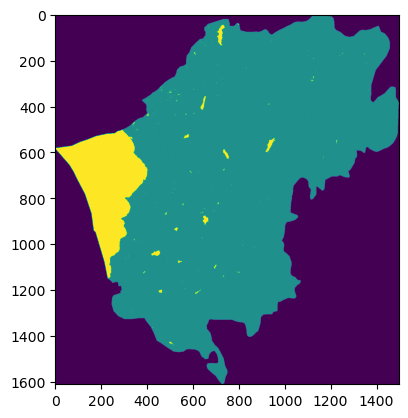

In [15]:
plt.imshow(mndwi_array)


主要函数：gdal.Polygonize()   
ref: https://gdal.org/api/python/osgeo.gdal.html    
用法：gdal.Polygonize(srcBand, maskBand, outLayer, iPixValField)   
**其中主要参数**: srcBand为输入数据波段，  
maskBand为掩膜波段（只对掩膜区域处理），  
outLayer为矢量化后的矢量图层，  
iPixValField为需要将DN值写入矢量字段的索引。  


In [17]:
path_mndwi2polygon = 'data/Section-5/s2_chenggong_mndwi_thre01_polygon.gpkg'
### 创建空矢量
prj = osr.SpatialReference()
prj.ImportFromWkt(dset.GetProjection())     ## 读取栅格数据的投影信息，用来为后面生成的矢量做准备
driver_vec = ogr.GetDriverByName("GPKG")
ds_vec = driver_vec.CreateDataSource(path_mndwi2polygon)  # 创建一个目标文件
poly_layer = ds_vec.CreateLayer('mndwi_polygon', srs=prj, geom_type=ogr.wkbMultiPolygon)  # 对shp文件创建一个图层，定义为多个面类
Field_DN = ogr.FieldDefn('DN', ogr.OFTInteger)  ## 定义要素字段
poly_layer.CreateField(Field_DN)
gdal.Polygonize(srcBand=mndwi_band, 
                maskBand=None, 
                outLayer=poly_layer, 
                iPixValField=0)   # 核心函数，执行的就是栅格转矢量操作
### 删除除特定DN值的其他矢量要素
DN_vec = [1]
for fea in poly_layer:
    DN_value = fea.GetField('DN')
    if DN_value not in DN_vec:
        poly_layer.DeleteFeature(fea.GetFID())

ds_vec = None  ## 保存并关闭文件



2.2. 矢量数据 -> 栅格数据   
主要函数：   
gdal.RasterizeLayer（dataset, bands, layer, options）
dataset:输出栅格数据；   
bands:指定要更新的波段，为list数据类型;   
layer:指定矢量图层；   
options:控制栅格化的参数。  
参考：https://gdal.org/api/python/osgeo.gdal.html 

In [2]:
path_vec = 'data/Section-5/s2_chenggong_mndwi_thre01_polygon.gpkg'
path_raster = 'data/Section-5/s2_chenggong_mndwi_thre01_polygon2raster.tif'


In [3]:
# Open the data source and read in the extent
dsource_vec = ogr.Open(path_vec)
layer_vec = dsource_vec.GetLayer()
proj_vec = layer_vec.GetSpatialRef()
proj_vec_wkt = proj_vec.ExportToWkt()
print(proj_vec_wkt)
x_min, x_max, y_min, y_max = layer_vec.GetExtent()


PROJCS["WGS 84 / UTM zone 48N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",105],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32648"]]


In [4]:
## Define pixel_size and geo_trans
pixel_size = 20
geo_trans = (x_min, pixel_size, 0, y_max, 0, -pixel_size)
# Create the destination data source
x_size = int((x_max - x_min) / pixel_size)
y_size = int((y_max - y_min) / pixel_size)
dset_raster = gdal.GetDriverByName('GTiff').Create(path_raster, 
                                        xsize=x_size, 
                                        ysize=y_size, 
                                        bands=1, 
                                        eType=gdal.GDT_Int16
                                        )
dset_raster.SetGeoTransform(geo_trans)
dset_raster.SetProjection(proj_vec_wkt)

0

In [5]:
# Rasterize
gdal.RasterizeLayer(dataset=dset_raster, bands=[1], layer=layer_vec, options=["ATTRIBUTE=DN"])
dset_raster = None


2.3 利用矢量数据对栅格数据进行裁剪    
函数：gdal.Warp()    
ref：https://gdal.org/api/python/osgeo.gdal.html    
函数用法：dset_subs = gdal.Warp(destNameOrDestDS, srcDSOrSrcDSTab, cutlineDSName)     
其中主要参数：  
destNameOrDestDS：为输出裁剪后图像路径，  
srcDSOrSrcDSTab为原始图像路径；   
cutlineDSName为矢量文件路径。    


In [ ]:
path_rsimg = 'data/Section-2/s2_kunming_chenggong_4bands_10m_wgs84.tif'
path_vec = 'data/Section-5/subs_1.gpkg'
path_rsimg_subs = 'data/Section-5/s2_kunming_chenggong_4bands_10m_subs1.tif'


In [ ]:
### ！应确保矢量数据所有要素的有效性（可用qgis检查）
dset_rsimg_subs = gdal.Warp(destNameOrDestDS = path_rsimg_subs, 
                            srcDSOrSrcDSTab = path_rsimg,                            
                            cutlineDSName = path_vec,
                            dstNodata=0)  ## dstNodata: 必填参数，值无关
dset_rsimg_subs = None
